In [59]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
%matplotlib inline
np.random.seed(42)

## At this stage we will read the files and create two separate data frames which will be joined later. In the original files we got two .csv files :ab_data and countries. Let's read them.

#### ab_data will be the first file to be read, the data will be stored on df_ab:

In [60]:
df_ab=pd.read_csv('ab_data.csv')
df_ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


### We need to know how many observations we get from the AB data frame

In [61]:
print('the number of observations from the ab table is {}'.format(df_ab.shape[0]))

the number of observations from the ab table is 294478


## the logic behind the A/B test
We have two groups : control and treatment, control is the group of users who used to use the old page, while treatment are the ones who did not to use the old_page. Both group are exposed to the two landing_page. The objective is to set up some rules to decide which of then landing_page the company should implement or perhaps run the experiment longer to make their decision. To decide, we will refer to the proportion of unique users visiting each page and decide to pay for the company's product. 
In this first section We are looking for the following information:
1. The number of unique users in the dataset
2. The number of unique users by group
3. The proportion of users converted
4. The number of time the new_page and treatment don't match
5. The proportion of control group who convert on old_page
6. The proportion of treatment group who convert on old_page
7. The proportion of control group who convert on new_page
8. The proportion of treatment group who convert on new_page

In [62]:
print('the number of unique usres in the dataset is {}'.format(df_ab['user_id'].nunique()))

the number of unique usres in the dataset is 290584


In [63]:
df_ab.groupby('group').user_id.nunique()

group
control      146195
treatment    146284
Name: user_id, dtype: int64

In [64]:
df_ab.groupby('converted').user_id.nunique()

converted
0    256275
1     35173
Name: user_id, dtype: int64

In [65]:
# proportion of users converted
print('the proportion of unique users converted is {}'.format(35173/291448))

the proportion of unique users converted is 0.1206836210919272


In [66]:
print('the proportion of users converted is {}'.format(df_ab.converted.mean()))

the proportion of users converted is 0.11965919355605512


In [67]:
# the number of time the new_page and treatment don't match
print('the number of time the new_page and treatment donnot match is {}'.format(df_ab.query('group=="treatment" & landing_page!="new_page"').count()[0]))

the number of time the new_page and treatment donnot match is 1965


In [68]:
# the number of time the old_page and control don't match
print('the number of time the old_page and control donnot match is {}'.format(df_ab.query('group=="control" & landing_page!="old_page"').count()[0]))

the number of time the old_page and control donnot match is 1928


In [69]:
# Do any of the rows have missing values?
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


As we see there are no missing data, which means there are 3893 rows for which we are not confident regarding the accuracy of the data. We will have to remove them in the datasets. To do this we will create a new dataset that meets the specifications.

In [70]:
df2=df_ab[((df_ab["group"]=='treatment')==(df_ab["landing_page"]=='new_page')) & ((df_ab["group"]=='control')==(df_ab["landing_page"]=='old_page'))]
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [71]:
df2.shape[0]

290585

In [72]:
df2[((df2['group']=='treatment')==(df2['landing_page']=='new_page'))==False].shape[0]

0

In [73]:
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

In [74]:
print('the number of unique users in df2 is {}'.format(df2.user_id.nunique()))

the number of unique users in df2 is 290584


In [75]:
sum(df2.duplicated())

0

In [76]:
#There is one user_id repeated in df2. What is it and in which row ?
dupes=df2['user_id'].duplicated()
print('the row in which the duplicated user_id and his number is {}'.format(df2['user_id'][dupes]))

the row in which the duplicated user_id and his number is 2893    773192
Name: user_id, dtype: int64


In [77]:
mask=df2.user_id.duplicated(keep=False)
print(df2[mask])

      user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0


In [78]:
df2.drop_duplicates(inplace=True)
df2.head()

C:\Users\Camoens\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [79]:
#What is the probability of an individual converting regardless of the page they rece
print('the probability of an individual converting regardless the page they receive is {}'.format(df2.converted.mean()))

the probability of an individual converting regardless the page they receive is 0.11959667567149027


In [80]:
#Given that an individual was in the control group, what is the probability they converted?
# P(C|CG)=P(CG,C)/P(CG)
# P(CG,C)=P(C)*P(CG|C)
# P(CG)=P(CG,C)+P(CG,~C)
P_CG_C=df2.query('group=="control" & converted=="1"').count()/df2.query('group =="control"').count()
PC=df2.converted.mean()
PCGC=PC*P_CG_C
P_CG_nC=df2.query('group=="control" & converted=="0"').count()/df2.query('group =="control"').count()
PCGnC=PC*P_CG_nC
PCG=PCGC+PCGnC
P_C_CG=(PC*P_CG_C)/PCG
print('the probability that given an individual was in the control group and they converted is {}'.format(P_C_CG))

the probability that given an individual was in the control group and they converted is user_id         0.120386
timestamp       0.120386
group           0.120386
landing_page    0.120386
converted       0.120386
dtype: float64


In [81]:
#Given that an individual was in the treatment group, what is the probability they converted?
# P(C|TG)=P(TG,C)/P(TG)
# P(TG,C)=P(C)*P(TG|C)
# P(TG)=P(TG,C)+P(TG,~C)
P_TG_C=df2.query('group=="treatment" & converted=="1"').count()/df2.query('group =="treatment"').count()
PC=df2.converted.mean()
PTGC=PC*P_TG_C
P_TG_nC=df2.query('group=="treatment" & converted=="0"').count()/df2.query('group =="treatment"').count()
PTGnC=PC*P_TG_nC
PTG=PTGC+PTGnC
P_C_TG=(PC*P_TG_C)/PTG
print('the probability that given an individual was in the treatment group and they converted is {}'.format(P_C_TG))

the probability that given an individual was in the treatment group and they converted is user_id         0.118807
timestamp       0.118807
group           0.118807
landing_page    0.118807
converted       0.118807
dtype: float64


In [82]:
P_npg=df2.query('landing_page=="new_page"').count()/df2['landing_page'].count()
print('the probability that an individual received the new page is {}'.format(P_npg))

the probability that an individual received the new page is user_id         0.500064
timestamp       0.500064
group           0.500064
landing_page    0.500064
converted       0.500064
dtype: float64


There is not sufficient evidence to conclude that the new treatment page leads to more conversions.

# PART 2 A/B TEST
We have to make the decision just based on all the data provided. We assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%
The null and alternative hypotheses are:
Null and alternatives hypothese:
H0: pnew <= pold (the converted rates for the new pages are equal or less than the converted rates for the old page)
H1: pnew >= pold (the converted rates for the new pages are equal or greater than the converted rates for the old page)

Let's assume under the null hypothesis,  𝑝𝑛𝑒𝑤  and  𝑝𝑜𝑙𝑑  both have "true" success rates equal to the converted success rate regardless of page - that is  𝑝𝑛𝑒𝑤  and  𝑝𝑜𝑙𝑑  are equal:
H0: pnew = pold = 0.1196

Perform the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null.

In [83]:
# What is the conversion rate for  𝑝𝑛𝑒𝑤  under the null?
new_df=df2.query('landing_page=="new_page"')
new_df.converted.mean()

0.11880724790277405

In [84]:
old_df=df2.query('landing_page=="old_page"')
old_df.converted.mean()

0.1203863045004612

In [85]:
# the conversion rate for pnew under the null:
print('the conversion rate for pnew under the null is {}'.format(df2.converted.mean()))

the conversion rate for pnew under the null is 0.11959667567149027


In [86]:
#What is the conversion rate for  𝑝𝑜𝑙𝑑  under the null?
print('the conversion rate for pold under the null is {}'.format(df2.converted.mean()))

the conversion rate for pold under the null is 0.11959667567149027


In [87]:
 # What is  𝑛𝑛𝑒𝑤 , the number of individuals in the treatment group?
new_df.shape[0]

145311

In [88]:
# What is  𝑛𝑜𝑙𝑑 , the number of individuals in the control group?
old_df.shape[0]

145274

In [89]:
# Simulate  𝑛𝑛𝑒𝑤  transactions with a conversion rate of  𝑝𝑛𝑒𝑤  under the null. 
#Store these  𝑛𝑛𝑒𝑤  1's and 0's in new_page_converted.
new_page_converted=[]
for _ in range(10000):
    nnew=df2.sample(new_df.shape[0],replace=True)
    nnew_mean=nnew.converted.mean()
    new_page_converted.append(nnew_mean)
new_page_converted=np.array(new_page_converted)
new_page_converted.mean()

0.11958922586727777

In [90]:
#Simulate  𝑛𝑜𝑙𝑑  transactions with a conversion rate of  𝑝𝑜𝑙𝑑  under the null. 
#Store these  𝑛𝑜𝑙𝑑  1's and 0's in old_page_converted.
old_page_converted=[]
for _ in range(10000):
    nold=df2.sample(old_df.shape[0],replace=True)
    nold_mean=nold.converted.mean()
    old_page_converted.append(nold_mean)
old_page_converted=np.array(old_page_converted)
old_page_converted.mean()

0.11959036992166527

In [91]:
diffs=[]
for i in range(10000):
    bsample=df2.sample(df2.shape[0],replace=True)
    old_conv=bsample.query('landing_page=="old_page"')['converted'].mean()
    new_conv=bsample.query('landing_page=="new_page"')['converted'].mean()
    diffs.append(old_conv-new_conv)

(array([  12.,   64.,  491., 1609., 2914., 2858., 1509.,  454.,   83.,
           6.]),
 array([-0.00322203, -0.00225762, -0.0012932 , -0.00032879,  0.00063563,
         0.00160005,  0.00256446,  0.00352888,  0.00449329,  0.00545771,
         0.00642213]),
 <a list of 10 Patch objects>)

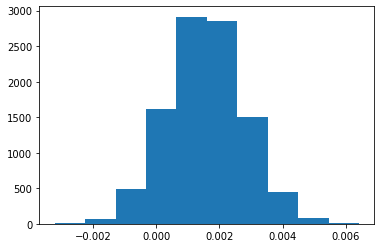

In [92]:
diffs=np.array(diffs)
plt.hist(diffs)

In [93]:
obs_diff=old_conv-new_conv

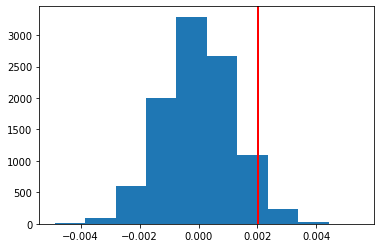

In [94]:
null_vals=np.random.normal(0,diffs.std(),diffs.size)
plt.hist(null_vals)
plt.axvline(x=obs_diff,c='r', linewidth=2)

In [124]:
(null_vals<obs_diff).mean()

0.9526

we failed to reject the null hypothesis
H0: pnew <= pold (the converted rates for the new pages are equal or less than the converted rates for the old page)

In [126]:
# z-score and p-value computed for old
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
convert_old = old_page_converted.mean()
n_old = old_df.shape[0]
stat, pval = proportions_ztest(convert_old, n_old)
print('{0:0.3f}'.format(pval))

ValueError: value must be provided for a 1-sample test

In [ ]:
# z-score and p-value computed for new
import  numpy as np
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
convert_old = 0.119590
convert_new = 0.119589
n_old = 145274
n_new = 145311
from statsmodels.stats.proportion import proportions_ztest
stat, pval = proportions_ztest(convert_old, n_old)
print('{0:0.3f}'.format(pval))

# Part 3. Logistic Regression

Since each row is either a conversion or no conversion, we suggest to use logistic regression which aims to predict the event of one from two possible outcomes. Here the two possible outcomes are either the visitors converted or not converted.

In the logistic model, converted is the response. We will use statsmodels to fit the logistic regression model, to see if there is a significant difference in conversion based on which page a customer receives.
Converted will be explained by the intercept and the ab_page which value is 1 when an individual receives the new_page and 0 if  the old_page. 

The hypothesis testing with this model:
H0: based on the page the customer receive there is no significant difference in conversion 
H1: There is a significant difference in conversion based on which page a customer receives

In [96]:
# Creation in df2 a column for the intercept
df2['intercept']=1

C:\Users\Camoens\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [99]:
# create a dummy variable column for which page each user received:
# ab_page column, which is 1 when an individual receives the treatment and 0 if control.
df2[['ab_page0','ab_page1']]=pd.get_dummies(df2['landing_page'])
#df2[['old_page','new_page']]=pd.get_dummies(df2['landing_page'])['ab_page']
df2=df2.drop('ab_page0',axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page1
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1


In [ ]:
print(df2['landing_page'].mean())

In [100]:
# We gonna use statsmodels to fit the logistic regression model.
df2['intercept']=1
logit_m=sm.Logit(df2['converted'], df2[['intercept','ab_page1']])
result=logit_m.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Dec 2019   Pseudo R-squ.:               8.085e-06
Time:                        16:13:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.147      0.000      -2.020      -1.988
ab_page1       0.0150      0.011      1.312      0.190      -0.007       0.037
==============================================================================
"""

In [101]:
np.exp(result.params)

intercept    0.134825
ab_page1     1.015110
dtype: float64

for each time a customer receive the old_page the converted rate tend to increase about 1.01 time, however the p-value of 0.19 associated with ab_page indicates that we failed to reject the null hypothesis, thus there is no significant difference in conversion either the customer receive the old_page or the new_page.

What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in Part II?
The hypothesis testing with this model:
H0: based on the page the customer receive there is no significant difference in conversion 
H1: There is a significant difference in conversion based on which page a customer receives

The null and alternative hypotheses are: 
H0: pnew <= pold (the converted rates for the new pages are equal or less than the converted rates for the old page) 
H1: pnew >= pold (the converted rates for the new pages are equal or greater than the converted rates for the old page)

 What is the p-value associated with ab_page? Why does it differ from the value you found in Part II?
 It's because for the hypothesis test this is a one-tailed test while the logistic regression uses a two-tailed test.

Hint: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in Part II?

Now, you are considering other things that might influence whether or not an individual converts. Discuss why it is a good idea to consider other factors to add into your regression model. Are there any disadvantages to adding additional terms into your regression model?

Adding additional terms into the model, can help to improve the stability of the model while increase the R^2

#### let's upload and read the data for countries and stored them on df_c:

In [102]:
df_c=pd.read_csv('./countries.csv')
df_c.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [106]:
df_c.groupby('country').user_id.nunique()

country
CA     14499
UK     72466
US    203619
Name: user_id, dtype: int64

#### How many observations we have on this data frame?

In [103]:
print('the number of observations on the countries table is {}'.format(df_c.shape[0]))

the number of observations on the countries table is 290584


## let's join the 2 tables df2 and df_c

In [119]:
df2.merge(df_c.set_index('user_id'), on='user_id')

,user_id,timestamp,group,landing_page,converted,intercept,ab_page1,country_x,country_y
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,US,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,US,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,US,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,US,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,US,US
...,...,...,...,...,...,...,...,...,...
290580,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,1,US,US
290581,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,1,US,US
290582,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,1,US,US
290583,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,1,US,US


In [120]:
df2[['country_US','country_CA','country_UK']]=pd.get_dummies(df2['country'])
df2=df2.drop('country_US',axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page1,country,country_CA,country_UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,US,0,1


In [127]:
#Does it appear that country had an impact on conversion?
df2['intercept']=1
logit_c=sm.Logit(df2['converted'], df2[['intercept','country_CA','country_UK']])
result_c=logit_c.fit()
result_c.summary()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            2
Date:                Thu, 12 Dec 2019   Pseudo R-squ.:               1.521e-05
Time:                        20:15:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1983
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
country_CA     0.0507      0.028      1.786      0.074      -0.005       0.106
country_UK     0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [128]:
np.exp(result_c.params)

intercept     0.130350
country_CA    1.052027
country_UK    1.041641
dtype: float64

in this case we failed to reject the null, we can conclude that country had no impact on conversion holding all else constant.

In [121]:
# we would now like to look at an interaction between page and country to see if there significant effects on conversion.
df2['intercept']=1
logit_m1=sm.Logit(df2['converted'], df2[['intercept','ab_page1','country_CA','country_UK']])
result1=logit_m1.fit()
result1.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Thu, 12 Dec 2019   Pseudo R-squ.:               2.324e-05
Time:                        17:43:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0450      0.027    -76.820      0.000      -2.097      -1.993
ab_page1       0.0150      0.011      1.308      0.191      -0.007       0.037
country_CA     0.0506      0.028      1.784      0.074      -0.005       0.106
country_UK     0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [122]:
np.exp(result1.params)

intercept     0.129383
ab_page1      1.015064
country_CA    1.051944
country_UK    1.041593
dtype: float64

As a conclusion, we can say that the interaction between page and country don't have effect on conversion. We failed to reject the null.